In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
from scipy.interpolate import UnivariateSpline
import scipy
%matplotlib inline
from tqdm.auto import tqdm
import quaternion as quat

In [2]:
def chi2(y1,y2,sy):
    '''
    Compute the Chi2 value.
    '''
    return(np.sum(np.square(x-y)/sy**2))

def ML15(q,earth,a,b,c,sun=[1,0,0]):
    '''
    Compute the M&L lightcurve model.
    '''
    sun = quat.from_vector_part(sun) # turn the sun point to a quaternion
    
    sun   = q *  sun  * q.inverse() # compute the sun vectors from rotations
    earth = q * earth * q.inverse() # compute the earth vectors from rotations
    
    # get the vector parts of both vector sets
    sun   = quat.as_vector_part(sun) 
    earth = quat.as_vector_part(earth)
    
    C = np.array([1/a**2,1/b**2,1/c**2]) # compute the scaling matrix C
    
    # compute the scaling constants Tsun, Tearth
    Tsun   = np.sqrt(np.einsum('ij,j,ij->i',sun,C,sun))
    Tearth = np.sqrt(np.einsum('ij,j,ij->i',earth,C,earth))
    
    # compute cos(alpha)
    cosa = np.einsum('ij,j,ij->i',sun,C,earth)/(Tearth*Tsun) 
    cosa = np.minimum(cosa,1)
    cosa = np.maximum(cosa,-1)
    
    # compute alpha
    aprime = np.arccos(cosa)
    aprime[np.isclose(aprime,0)]=0
    
    # compute scaling constant T
    T=np.sqrt(np.abs(Tsun**2 + Tearth**2 + 2*Tsun*Tearth*cosa))
    
    # compute cos(lambda) and sin(lambda)
    cosl=np.nan_to_num((Tsun+Tearth*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((Tearth*np.sin(aprime))/T,posinf=0,neginf=0)

    # compute the lambda values
    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    # compute the tan and cotan
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    # compute the M&L brightness
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    
    return(np.abs(L))

def ellipse_grad(r,a,b,c):
    '''
    Compute the gradient of the ellipse.
    '''
    x,y,z = r
    return((x**2/a**4+y**2/b**4+z**2/c**4)**(-1/2)*np.array([x/a**2,y/b**2,z/c**2]))

def matquatmul(A,q):
    '''
    Compute the matrix multiplication of a 4x4 matrix A and 
    the 4-vector representation of a quaternion q. 
    '''
    assert(A.shape==(4,4))
    return(quat.from_float_array(np.dot(A,quat.as_float_array(q))))

def quatdot(q1,q2):
    '''
    Compute the "quaternion dot product", which is the dot product if the quaternions 
    are in 4-vector form. 
    '''
    return(np.quaternion(np.dot(quat.as_float_array(q1),
                  quat.as_float_array(q2)),0,0,0))

def compMoI(a,b,c):
    return(1/5*np.array([b**2+c**2,a**2+c**2,a**2+b**2]))

def substellarpt(q,a,b,c,sun=[1,0,0]):
    '''
    Compute the sub-stellar point. 
    '''
    Ia,Ib,Ic = compMoI(a,b,c) 
    C = np.diag([0,a,b,c])
    
    sun = q.inverse()*np.quaternion(0,*sun)*q

    norm = np.sqrt(np.norm(matquatmul(C,sun)))
    
    rss = matquatmul(C**2,sun)/norm
    
    if np.abs(matquatmul(np.diag([0,1/a**2,1/b**2,1/c**2]),(q.inverse()*rss*q)))<0:
        rss *= -1
    
    return(rss)

def RK42d(t,x0,y0,f,g,dt=1,args=()):
    '''
    Computes the classic Runge-Kutta for 2 equations in 1 dimension. 
    
    Assumes that the equations are dx1/dxt = f, dx2/dt = g. 
    The function arguments should be t,x1,x2, and args.
    '''
    k1 = f(t,x0,y0,*args)
    l1 = g(t,x0,y0,*args)
    
    k2 = f(t+dt/2,x0+k1/2,y0+l1/2,*args)
    l2 = g(t+dt/2,x0+k1/2,y0+l1/2,*args)
    
    k3 = f(t+dt/2,x0+k2/2,y0+l2/2,*args)
    l3 = g(t+dt/2,x0+k2/2,y0+l2/2,*args)
    
    k4 = f(t+dt,x0+k3,y0+l3,*args)
    l4 = f(t+dt,x0+k3,y0+l3,*args)
    
    tn = t+dt
    xn = x0 + dt/6*(k1+2*k2+2*k3+k4)
    yn = y0 + dt/6*(l1+2*l2+2*l3+l4)

    return(tn,xn,yn)
    
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    rss = substellarpt(qp,a,b,c).vec
    return(M*A*np.quaternion(0,*np.cross(rss,ellipse_grad(rss,a,b,c))))


def computestep(t0,qp0,dqp0,a,b,c,dt=1):
    '''
    Compute and update the rotation and position axes from the torque. 
    
    Uses a 4th-order Runge-Kutta on a system of equations. 
    '''
    Ia,Ib,Ic = compMoI(a,b,c)
    
    I = np.diag([1,Ia,Ib,Ic])
    Iinv = np.linalg.inv(I)
    
    
    # NOTE: q1 = qp, q2 = dq1/dt
    f = lambda t,q1,q2 : q2
    def g(t,q1,q2):
        w = q2*q1.inverse()
        w.w = 0

        tau = comptorque(q1,a,b,c)
        tau = np.quaternion(0,0,0,0)
        
        Iw = matquatmul(I,w)
        
        innerterm = tau - 4*w*Iw - 4*quatdot(w,Iw)
        
        return(w*q2 + .5*matquatmul(Iinv,innerterm)*q1)
        
    tn,qpn,dqpn = RK42d(t0,qp0,dqp0,f,g,dt)
    qpn *= 1/np.abs(qpn)
    return(tn,qpn,dqpn)

In [3]:
P = 10

qp = np.quaternion(1,0,0,0) # initial quaternion attitude
qw = np.quaternion(0,0,2*np.pi/P,0) # initial angular velocity quaternion (NOT dqp/dt!)

dqp = .5*qw*qp # initial dqp/dt quaternion

t = 0
dt = .1

att = []
time = []

while t<20:
    time.append(t)
    att.append(qp)
    
    t,qp,dqp = computestep(t,qp,dqp,6,6,1,dt)

(200, 4)


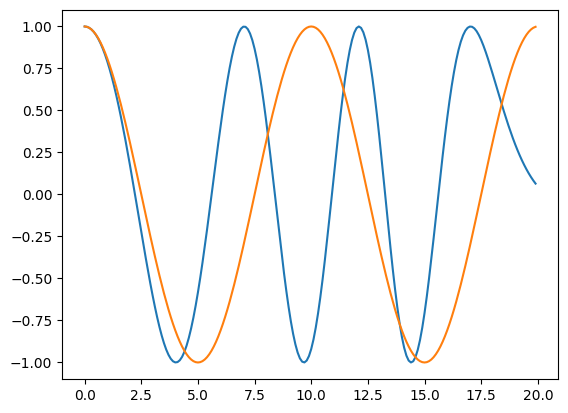

In [5]:
att = np.array(att)

sun = np.quaternion(0,1,0,0)

sunatt = att*sun*att.conj()

sunatt = quat.as_float_array(sunatt)
tatt=(np.cos(2*np.pi*(np.array(time)%P)/P))

print(sunatt.shape)
plt.plot(time,sunatt[:,1])
plt.plot(time,tatt)
plt.show()

In [406]:
qw = np.quaternion(0,0,2*np.pi/P,0)
dt = 1
qp = np.quaternion(1,0,0,0)

qpp = np.exp(qw*dt/2)*qp

print(qpp*np.quaternion(0,1,0,0)*qpp.inverse())

quaternion(0, 0.809016994374947, 0, -0.587785252292473)
